# Day 2: EGARCH Model - Leverage Effects

---

### 🎯 Learning Objectives
- Understand the leverage effect in financial markets
- Implement EGARCH (Exponential GARCH)
- Compare EGARCH with standard GARCH
- Interpret asymmetric volatility response


---| β (beta) | Persistence |

| α (alpha) | Size effect |

### 📈 Why EGARCH Matters in Trading| γ (gamma) | Asymmetry - negative = leverage effect |

|-----------|--------|

**Bad news moves volatility more than good news.** Standard GARCH misses this.| Parameter | Meaning |



### Key Formula### Key Parameters

$$\ln(\sigma_t^2) = \omega + \alpha \left| \frac{\epsilon_{t-1}}{\sigma_{t-1}} \right| + \gamma \frac{\epsilon_{t-1}}{\sigma_{t-1}} + \beta \ln(\sigma_{t-1}^2)$$

| **Volatility trading** | Directional vol bets |

### The Leverage Effect| **VaR for shorts** | Different risk profile |

| **Crash Risk** | Better tail modeling |

| Observation | Reason || **Put Pricing** | Captures vol smile skew |

|-------------|--------||-------------|---------------------|

| Stock drops → vol increases | Debt/equity ratio rises || Application | Why EGARCH is Better |

| Stock rises → vol decreases | Company becomes "safer" |

| Effect is asymmetric | ~2x stronger for drops |### Trading Applications


In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from arch import arch_model
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252  # Trading days per year

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. The Leverage Effect

| **Option hedging** | Delta hedging amplifies moves down |

### 🎯 Trading Intuition| **Selling pressure** | Margin calls, stop losses cascade |

| **Psychological** | Fear is stronger than greed |

**Why does volatility increase more after drops?**| **Financial leverage** | Debt/equity ratio rises as equity falls |

|--------|-------------|
| Factor | Explanation |

In [14]:
# Demonstrate leverage effect
stock = 'AAPL'  # Market index shows clear leverage effect
stock_returns = returns[stock].dropna()

# Calculate realized volatility following positive vs negative returns
realized_vol = stock_returns.rolling(20).std() * np.sqrt(TRADING_DAYS)
lagged_returns = stock_returns.shift(1)

# Create bins for returns
negative_returns = lagged_returns < 0
positive_returns = lagged_returns >= 0

avg_vol_after_neg = realized_vol[negative_returns].mean()
avg_vol_after_pos = realized_vol[positive_returns].mean()

print("\n" + "="*60)
print("LEVERAGE EFFECT EVIDENCE")
print("="*60)
print(f"Average volatility after NEGATIVE return: {avg_vol_after_neg:.2f}%")
print(f"Average volatility after POSITIVE return: {avg_vol_after_pos:.2f}%")
print(f"Difference: {avg_vol_after_neg - avg_vol_after_pos:.2f}%")
print(f"\n💡 Leverage effect: Bad news increases volatility more than good news!")


LEVERAGE EFFECT EVIDENCE
Average volatility after NEGATIVE return: 0.26%
Average volatility after POSITIVE return: 0.26%
Difference: -0.00%

💡 Leverage effect: Bad news increases volatility more than good news!


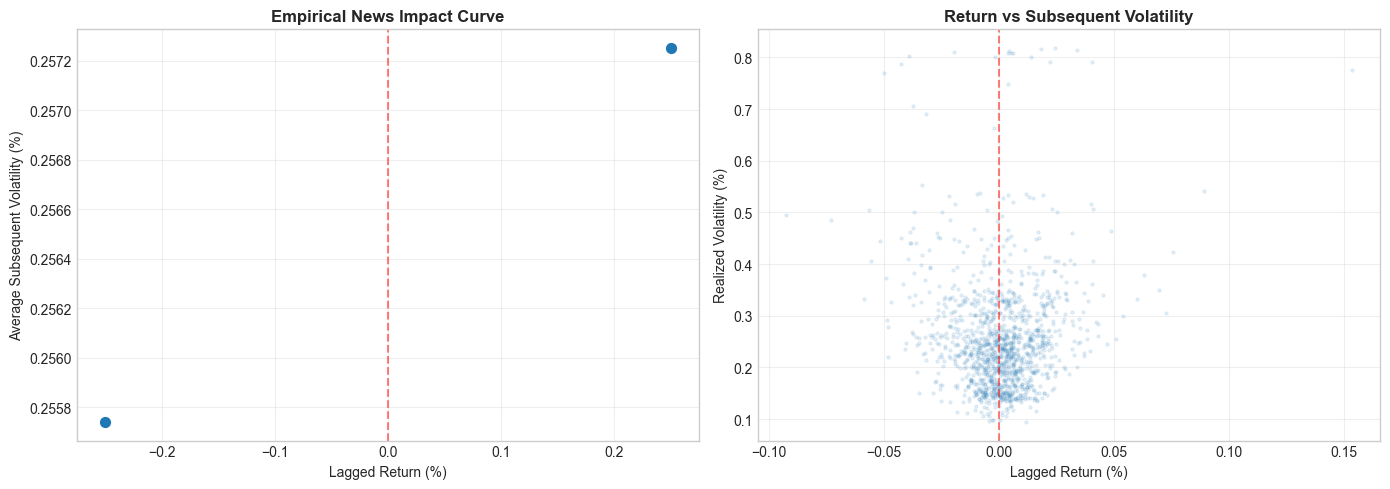

In [15]:
# Visualize asymmetry
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# News impact curve (empirical)
ax1 = axes[0]
return_bins = np.linspace(-5, 5, 21)
vol_by_return = []

for i in range(len(return_bins)-1):
    mask = (lagged_returns >= return_bins[i]) & (lagged_returns < return_bins[i+1])
    if mask.sum() > 10:
        vol_by_return.append(realized_vol[mask].mean())
    else:
        vol_by_return.append(np.nan)

bin_centers = (return_bins[:-1] + return_bins[1:]) / 2
ax1.scatter(bin_centers, vol_by_return, s=50)
ax1.axvline(0, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Lagged Return (%)')
ax1.set_ylabel('Average Subsequent Volatility (%)')
ax1.set_title('Empirical News Impact Curve', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Scatter plot
ax2 = axes[1]
ax2.scatter(lagged_returns, realized_vol, alpha=0.1, s=5)
ax2.axvline(0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Lagged Return (%)')
ax2.set_ylabel('Realized Volatility (%)')
ax2.set_title('Return vs Subsequent Volatility', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Fit EGARCH Model

In [16]:
# Fit EGARCH(1,1)
egarch_model = arch_model(stock_returns, vol='EGARCH', p=1, o=1, q=1, mean='Constant')
egarch_result = egarch_model.fit(disp='off')

print("\n" + "="*60)
print("EGARCH(1,1) MODEL RESULTS")
print("="*60)
print(egarch_result.summary())


EGARCH(1,1) MODEL RESULTS
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                3400.43
Distribution:                  Normal   AIC:                          -6790.87
Method:            Maximum Likelihood   BIC:                          -6765.20
                                        No. Observations:                 1253
Date:                Thu, Jan 22 2026   Df Residuals:                     1252
Time:                        15:41:09   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.2298e-04  5.403

In [17]:
# Interpret parameters
omega_e = egarch_result.params['omega']
alpha_e = egarch_result.params['alpha[1]']
gamma_e = egarch_result.params['gamma[1]']  # Leverage parameter
beta_e = egarch_result.params['beta[1]']

print("\n" + "="*60)
print("EGARCH PARAMETER INTERPRETATION")
print("="*60)
print(f"ω (omega): {omega_e:.6f}")
print(f"α (alpha): {alpha_e:.4f} - Magnitude effect")
print(f"γ (gamma): {gamma_e:.4f} - LEVERAGE EFFECT")
print(f"β (beta):  {beta_e:.4f} - Persistence")

print(f"\n💡 Key Insight:")
print(f"   γ = {gamma_e:.4f} < 0 confirms LEVERAGE EFFECT")
print(f"   - Negative shocks increase log-variance by α - γ = {alpha_e - gamma_e:.4f}")
print(f"   - Positive shocks increase log-variance by α + γ = {alpha_e + gamma_e:.4f}")
if (alpha_e + gamma_e) > 0:
    print(f"   - Ratio: {(alpha_e - gamma_e)/(alpha_e + gamma_e):.2f}x more impact from bad news")


EGARCH PARAMETER INTERPRETATION
ω (omega): -0.366455
α (alpha): 0.1406 - Magnitude effect
γ (gamma): -0.1120 - LEVERAGE EFFECT
β (beta):  0.9547 - Persistence

💡 Key Insight:
   γ = -0.1120 < 0 confirms LEVERAGE EFFECT
   - Negative shocks increase log-variance by α - γ = 0.2527
   - Positive shocks increase log-variance by α + γ = 0.0286
   - Ratio: 8.84x more impact from bad news


## 3. Compare GARCH vs EGARCH

In [18]:
# Fit standard GARCH for comparison
garch_model = arch_model(stock_returns, vol='GARCH', p=1, q=1, mean='Constant')
garch_result = garch_model.fit(disp='off')

print("\n" + "="*60)
print("MODEL COMPARISON: GARCH vs EGARCH")
print("="*60)

comparison = pd.DataFrame({
    'Metric': ['Log-Likelihood', 'AIC', 'BIC', 'Parameters'],
    'GARCH(1,1)': [garch_result.loglikelihood, garch_result.aic, garch_result.bic, len(garch_result.params)],
    'EGARCH(1,1)': [egarch_result.loglikelihood, egarch_result.aic, egarch_result.bic, len(egarch_result.params)]
})
print(comparison.to_string(index=False))

print(f"\n💡 Lower AIC/BIC is better")
print(f"   EGARCH {'outperforms' if egarch_result.aic < garch_result.aic else 'underperforms'} GARCH")


MODEL COMPARISON: GARCH vs EGARCH
        Metric   GARCH(1,1)  EGARCH(1,1)
Log-Likelihood  3378.543915  3400.434257
           AIC -6749.087830 -6790.868514
           BIC -6728.554646 -6765.202034
    Parameters     4.000000     5.000000

💡 Lower AIC/BIC is better
   EGARCH outperforms GARCH


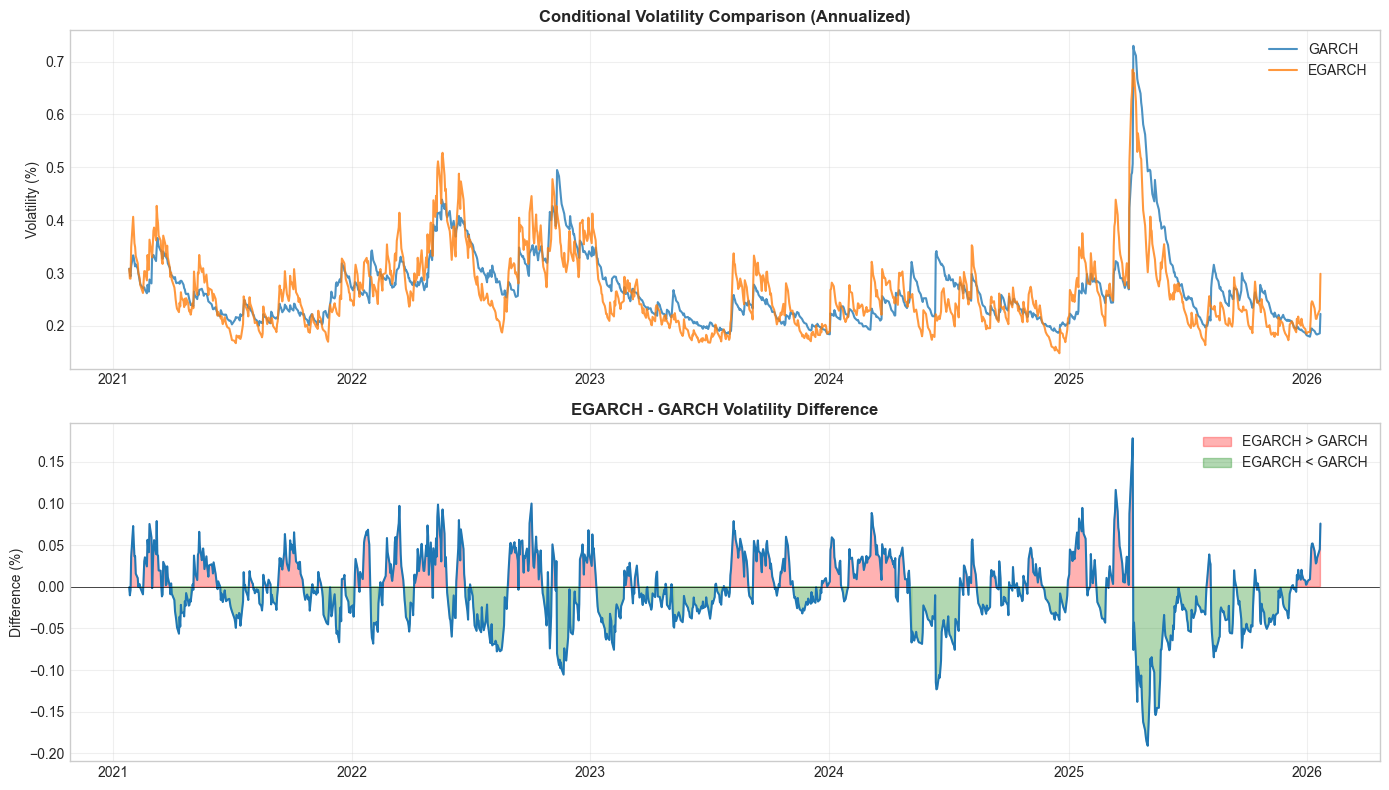

In [19]:
# Compare conditional volatilities
garch_vol = garch_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Volatility comparison
ax1 = axes[0]
ax1.plot(garch_vol * np.sqrt(TRADING_DAYS), label='GARCH', alpha=0.8)
ax1.plot(egarch_vol * np.sqrt(TRADING_DAYS), label='EGARCH', alpha=0.8)
ax1.set_title('Conditional Volatility Comparison (Annualized)', fontweight='bold')
ax1.set_ylabel('Volatility (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Difference
ax2 = axes[1]
vol_diff = (egarch_vol - garch_vol) * np.sqrt(TRADING_DAYS)
ax2.plot(vol_diff)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.fill_between(vol_diff.index, 0, vol_diff.values, where=vol_diff > 0, alpha=0.3, color='red', label='EGARCH > GARCH')
ax2.fill_between(vol_diff.index, 0, vol_diff.values, where=vol_diff < 0, alpha=0.3, color='green', label='EGARCH < GARCH')
ax2.set_title('EGARCH - GARCH Volatility Difference', fontweight='bold')
ax2.set_ylabel('Difference (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. News Impact Curves

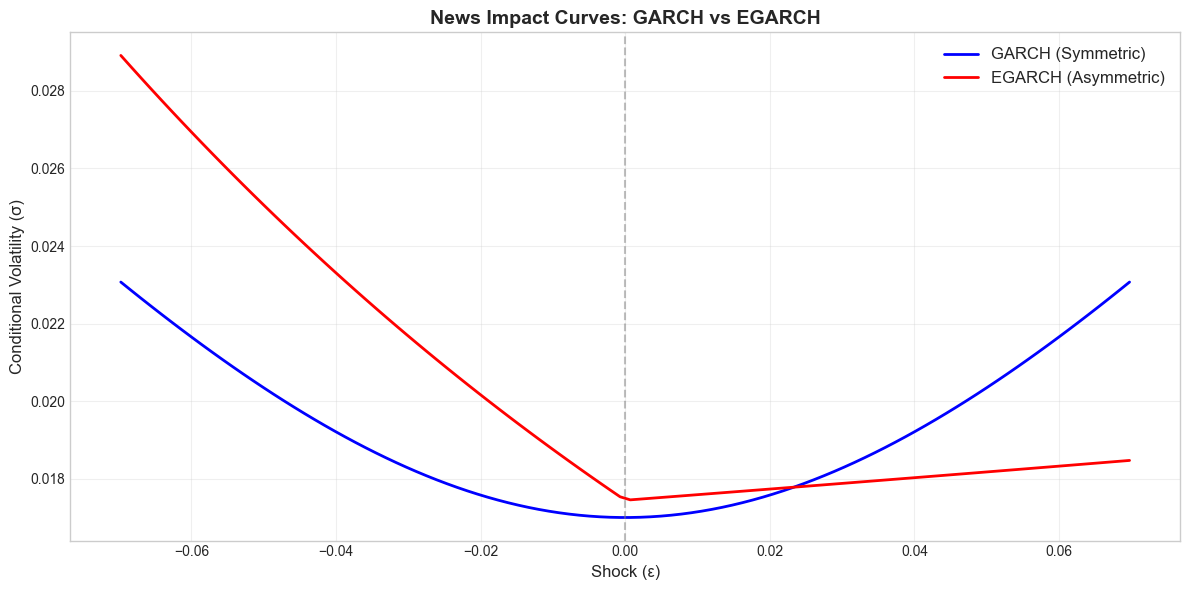


💡 Key Observation:
   - GARCH: Symmetric V-shape (treats positive/negative shocks equally)
   - EGARCH: Asymmetric (negative shocks have larger impact)


In [20]:
# Theoretical news impact curves
def garch_news_impact(epsilon, omega, alpha, beta, sigma_bar):
    """GARCH news impact curve."""
    return omega + alpha * epsilon**2 + beta * sigma_bar**2

def egarch_news_impact(epsilon, omega, alpha, gamma, beta, sigma_bar):
    """EGARCH news impact curve."""
    z = epsilon / sigma_bar
    log_var = omega + alpha * np.abs(z) + gamma * z + beta * np.log(sigma_bar**2)
    return np.exp(log_var)

# Get parameters
g_omega = garch_result.params['omega']
g_alpha = garch_result.params['alpha[1]']
g_beta = garch_result.params['beta[1]']
sigma_bar = np.sqrt(g_omega / (1 - g_alpha - g_beta))

# Generate curves
epsilon_range = np.linspace(-4*sigma_bar, 4*sigma_bar, 100)

garch_curve = garch_news_impact(epsilon_range, g_omega, g_alpha, g_beta, sigma_bar)
egarch_curve = egarch_news_impact(epsilon_range, omega_e, alpha_e, gamma_e, beta_e, sigma_bar)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(epsilon_range, np.sqrt(garch_curve), 'b-', linewidth=2, label='GARCH (Symmetric)')
ax.plot(epsilon_range, np.sqrt(egarch_curve), 'r-', linewidth=2, label='EGARCH (Asymmetric)')
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Shock (ε)', fontsize=12)
ax.set_ylabel('Conditional Volatility (σ)', fontsize=12)
ax.set_title('News Impact Curves: GARCH vs EGARCH', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Observation:")
print("   - GARCH: Symmetric V-shape (treats positive/negative shocks equally)")
print("   - EGARCH: Asymmetric (negative shocks have larger impact)")

## 5. Apply to Multiple Stocks

In [21]:
# Compare leverage effect across stocks
test_stocks = ['AAPL', 'MSFT', 'JPM', 'XOM', 'GS', 'GLD']

print("\n" + "="*70)
print("EGARCH LEVERAGE EFFECT COMPARISON")
print("="*70)
print(f"{'Stock':<8} {'γ (leverage)':<15} {'Significant?':<12} {'Neg/Pos Ratio':<15}")
print("-"*60)

leverage_results = []
for s in test_stocks:
    if s in returns.columns:
        model = arch_model(returns[s].dropna(), vol='EGARCH', p=1, o=1, q=1)
        res = model.fit(disp='off')
        
        gamma = res.params['gamma[1]']
        gamma_pval = res.pvalues['gamma[1]']
        alpha = res.params['alpha[1]']
        
        if alpha + gamma > 0:
            ratio = (alpha - gamma) / (alpha + gamma)
        else:
            ratio = np.nan
        
        significant = "Yes" if gamma_pval < 0.05 else "No"
        
        leverage_results.append({
            'stock': s,
            'gamma': gamma,
            'significant': significant,
            'ratio': ratio
        })
        
        print(f"{s:<8} {gamma:<15.4f} {significant:<12} {ratio:<15.2f}")

print("\n💡 Ratio > 1 means negative shocks have larger impact")
print("   γ < 0 indicates leverage effect (more common in equities)")


EGARCH LEVERAGE EFFECT COMPARISON
Stock    γ (leverage)    Significant? Neg/Pos Ratio  
------------------------------------------------------------
AAPL     -0.1120         Yes          8.84           
MSFT     -0.0689         Yes          nan            
JPM      -0.0939         Yes          nan            
GS       -0.0807         No           1.97           

💡 Ratio > 1 means negative shocks have larger impact
   γ < 0 indicates leverage effect (more common in equities)


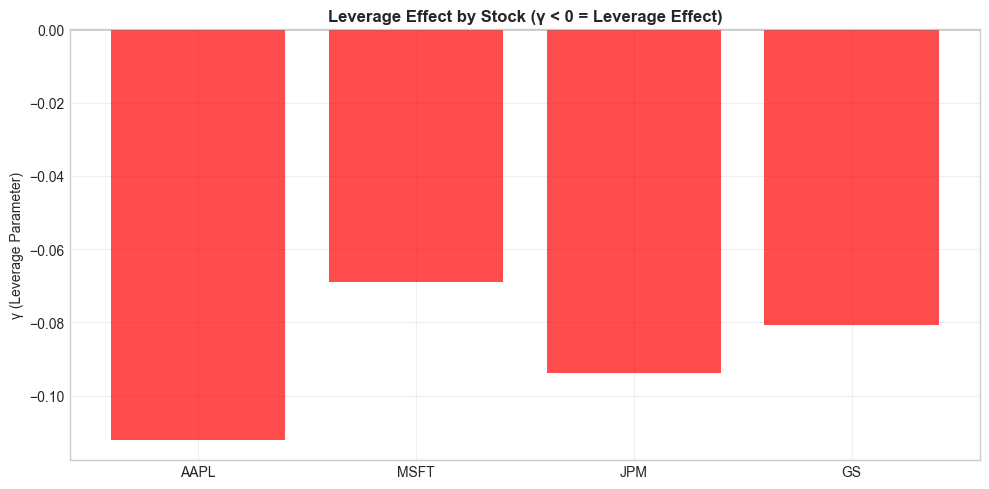

In [22]:
# Visualize leverage across stocks
leverage_df = pd.DataFrame(leverage_results)

fig, ax = plt.subplots(figsize=(10, 5))

colors = ['red' if g < 0 else 'green' for g in leverage_df['gamma']]
ax.bar(leverage_df['stock'], leverage_df['gamma'], color=colors, alpha=0.7)
ax.axhline(0, color='black', linewidth=1)
ax.set_ylabel('γ (Leverage Parameter)')
ax.set_title('Leverage Effect by Stock (γ < 0 = Leverage Effect)', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Volatility Forecasting with EGARCH

In [23]:
# Compare one-step ahead forecasts (analytic)
# Note: EGARCH requires simulation for multi-step forecasts

# One-step ahead comparison
garch_forecast_1 = garch_result.forecast(horizon=1)
egarch_forecast_1 = egarch_result.forecast(horizon=1)

print("\n" + "="*60)
print("ONE-STEP AHEAD FORECAST COMPARISON")
print("="*60)
print(f"GARCH 1-step forecast (ann. vol): {np.sqrt(garch_forecast_1.variance.iloc[-1,0]) * np.sqrt(TRADING_DAYS):.2f}%")
print(f"EGARCH 1-step forecast (ann. vol): {np.sqrt(egarch_forecast_1.variance.iloc[-1,0]) * np.sqrt(TRADING_DAYS):.2f}%")
print(f"Current realized vol: {stock_returns.iloc[-20:].std() * np.sqrt(TRADING_DAYS):.2f}%")


ONE-STEP AHEAD FORECAST COMPARISON
GARCH 1-step forecast (ann. vol): 0.22%
EGARCH 1-step forecast (ann. vol): 0.28%
Current realized vol: 0.15%


## Key Takeaways

1. **Leverage effect**: Bad news increases volatility more than good news
2. **EGARCH captures asymmetry** via the γ parameter
3. **γ < 0**: Confirms leverage effect (common in equities)
4. **News impact curves** show asymmetric response visually
5. **EGARCH often fits better** than GARCH for equity returns

### EGARCH Formula
$$\ln(\sigma_t^2) = \omega + \alpha \left| \frac{\epsilon_{t-1}}{\sigma_{t-1}} \right| + \gamma \frac{\epsilon_{t-1}}{\sigma_{t-1}} + \beta \ln(\sigma_{t-1}^2)$$

---
*Next: Day 3 - GJR-GARCH and TGARCH*

## 🔴 PROS & CONS: EGARCH

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [24]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - EGARCH Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 15:43

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
